# Using LightGBM on an example Dataset

In [13]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt


print('done!')

done!


## Loading the Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Visitas,Slot_Win,Mesa_Win,NCC,FP,FNN,MP,AABB,HOTEL,WinNeto,...,ANTIGUEDAD_DIAS,TBV_MEAN,TBV_Q25,TBV_Q50,TBV_Q75,SEGMENTO_VENDETTA,GENERO,CASINO_CLIENTE,label,PTS_ULT_ANIO
0,11.729167,1.715265e+03,2.351343e+06,135633.125000,0.0,0.0,0.0,85615.000000,7.957795e+05,2.217425e+06,...,5113,2.479592,1.00,1.0,3.00,Ad,M,A,cambio_genera_juego,570403.0
1,2.641026,1.884596e+05,1.246738e+03,10051.282051,0.0,0.0,0.0,2009.358974,0.000000e+00,1.796550e+05,...,5108,12.067797,3.00,8.0,20.50,De,H,A,cambio_NOgenera_juego,11207.0
2,16.500000,8.757794e+06,8.062500e+01,977833.333333,0.0,0.0,0.0,57498.395833,1.089580e+06,7.780041e+06,...,5038,1.838791,1.00,1.0,2.00,So,M,A,cambio_genera_juego,909780.0
3,1.200000,6.740300e+03,3.840000e+02,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,7.124300e+03,...,5095,276.500000,138.25,276.5,414.75,Pa,H,A,cambio_genera_juego,64.0
4,9.547619,9.984814e+05,0.000000e+00,70000.000000,0.0,0.0,0.0,7805.000000,0.000000e+00,9.284814e+05,...,5103,3.989011,1.00,2.0,4.00,De,M,A,cambio_genera_juego,133595.0


## Generating a Pandas Profiling

In [6]:
# generate the profile
profile = ProfileReport(df, title="Profiling Report", explorative=False)
# now save it!
profile.to_file("Profiling.html")


Summarize dataset:   0%|          | 0/59 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Train LightGBM Model

In [3]:
# set the label and values
y = df['label'].copy()
x = df.copy()
x.drop('label', inplace=True, axis=1)

# we need to transform categorical items in the set to 'category'
for col in x.columns:
    if x[col].dtype == 'object':
        x[col] = x[col].astype('category')

# transform labels to binary
y = [int(val == 'cambio_genera_juego') for val in y]

# split into test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# create lgbm datasets
train_data = lgb.Dataset(x_train, label=y_train)
eval_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

In [5]:
# train the model
parameters = {
        'objective': 'binary',
        'metric': 'auc',
        #'is_unbalance': 'true',
        'scale_pos_weight': 0.1,
        'boosting': 'dart',
        #'num_leaves': 31,
        #'max_depth': 10,
        'learning_rate': 0.01,
        #'verbose': 1,
        'max_cat_to_onehot': 7,
        'bagging_freq': 10,
        'feature_fraction': 0.9
    }

num_round = 1000
bst = lgb.train(parameters, train_data, num_round, eval_data, verbose_eval=0)

[LightGBM] [Info] Number of positive: 823, number of negative: 290
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7685
[LightGBM] [Info] Number of data points in the train set: 1113, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739443 -> initscore=1.043075
[LightGBM] [Info] Start training from score 1.043075


c:\users\kristofher\pycharmprojects\frankie-is-god\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\kristofher\pycharmprojects\frankie-is-god\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [6]:
# Print Confusion Matrix
metrics.confusion_matrix(y_test, bst.predict(x_test)>0.5)


array([[ 71,  56],
       [159, 192]], dtype=int64)

## Using Model With Focal Loss

In [7]:
# Define gradient functions
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess


def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	p = 1/(1+np.exp(-y_pred))
	loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
	return 'focal_loss', np.mean(loss), False

In [8]:
# using tried focal loss parameters alpha and gamma
alpha = 0.01
gamma = 0
focal_loss = lambda _x,_y: focal_loss_lgb(_x, _y, alpha, gamma)
eval_error = lambda _x,_y: focal_loss_lgb_eval_error(_x, _y, alpha, gamma)

parameters = {
    'objective': 'binary',
    #'metric': 'auc',
    #'is_unbalance': 'true',
    #'scale_pos_weight': pos_weight,
    'boosting': 'dart',
    #'num_leaves': args.num_leaves,
    #'max_depth': args.max_depth,
    #'learning_rate': args.learning_rate,
    'verbose': 1,
    'max_cat_to_onehot': 7,
    'bagging_freq': 10,
    'feature_fraction': 0.9
}
num_round = 100
focal_model = lgb.train(parameters, train_data, num_round, eval_data, verbose_eval=0,
                        fobj=focal_loss, feval=eval_error)

# Print Confusion Matrix
confusion = metrics.confusion_matrix(y_test, focal_model.predict(x_test)>0.5)
print(confusion)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7685
[LightGBM] [Info] Number of data points in the train set: 1113, number of used features: 44
[LightGBM] [Warning] Using self-defined objective function
[[115  12]
 [282  69]]


In [10]:
alphas = np.linspace(0, 1, 10)
gammas = np.linspace(0, 10, 10)

models = []
a = []
g = []
confusions = []
accuracies = []

for alpha in alphas:
    for gamma in gammas:
        focal_loss = lambda _x,_y: focal_loss_lgb(_x, _y, alpha, gamma)
        eval_error = lambda _x,_y: focal_loss_lgb_eval_error(_x, _y, alpha, gamma)
        a.append(alpha)
        g.append(gamma)
        temp_model = lgb.train(parameters, train_data, num_round, eval_data, verbose_eval=0,
                               fobj=focal_loss, feval=eval_error)
        models.append(temp_model)

        y_pred = temp_model.predict(x_test) > 0.5
        confusions.append(metrics.confusion_matrix(y_test, y_pred))
        accuracies.append(metrics.accuracy_score(y_test, y_pred))


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7685
[LightGBM] [Info] Number of data points in the train set: 1113, number of used features: 44
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

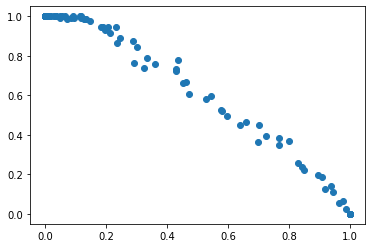

In [19]:
precisions = []
recalls = []

for confusion in confusions:
    recall = confusion[0,0]/(confusion[0,0] + confusion[0,1])
    recalls.append(recall)

    precision = confusion[1,1]/(confusion[1,0] + confusion[1,1])
    precisions.append(precision)

ratio = [rec*prec for rec, prec in zip(recalls, precisions)]

plt.scatter(precisions, recalls)
plt.show()